In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import census
import us
from scipy import stats
warnings.simplefilter("ignore") 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from tqdm import tqdm
from itertools import combinations, chain
import osmnx as ox

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap

In [2]:
parkvars=gpd.read_file('S:/376/Spring22/jkchap16/multipoly_accessibility_vars.shp')
parkvars['parkx']=parkvars.geometry.centroid.x
parkvars['parky']=parkvars.geometry.centroid.y
parkvars.head()
parkvars['amenity_c']=parkvars['fountain_c']+parkvars['athletic_c']+parkvars['cpa_count']
parkvars=parkvars[parkvars['landuse']!='Garden']

In [3]:
nyc_acs=pd.read_csv('S:/376/Spring22/jkchap16/nyc_acs.csv')
nyc_acs['GEOID']=nyc_acs['GEOID'].astype('str')
nyc_acs.med_age[nyc_acs['med_age'] < 0] = 0
nyc_acs.med_income[nyc_acs['med_income'] < 0] = 0

In [4]:
tracts=gpd.read_file('S:/376/Spring22/jkchap16/nyc_tract.zip')
tracts.to_crs(epsg='3857', inplace=True)
tracts['tractx']=tracts.geometry.centroid.x
tracts['tracty']=tracts.geometry.centroid.y

In [5]:
tracts_acs=tracts.merge(nyc_acs, on='GEOID')
tracts_acs.fillna(0, inplace=True)
tracts_acs=tracts_acs[tracts_acs['total'] >50]
tracts_acs['tract_area']=tracts_acs.geometry.area
tracts_acs['pop_den']=tracts_acs['total']/tracts_acs['tract_area']

In [6]:
# the county codes are 
codes={'manhattan':'061', 'staten_island':'085','bronx':'005', 'queens':'081', 'brooklyn':'047'}

In [7]:
tracts_acs.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'tractx', 'tracty', 'Unnamed: 0', 'name', 'total', 'nhwhite', 'nhblack',
       'nhindian', 'nhasian', 'nhislander', 'latino', 'med_income', 'poverty',
       'hs_diploma', 'college_diploma', 'unemployed', 'med_age', 'noncitizen',
       'SNAP', 'state', 'county', 'tract', 'percent_white', 'percent_black',
       'percent_asian', 'percent_latino', 'percent_poverty',
       'percent_hsdiploma', 'percent_college_diploma', 'percent_unemployed',
       'percent_indian', 'percent_islander', 'percent_SNAP',
       'percent_noncitizen'],
      dtype='object')

# Prepare street info

roads=ox.graph_from_place('New York City', network_type= 'drive')
ox.plot_graph(roads)

In [126]:
roads = ox.speed.add_edge_speeds(roads)
roads = ox.speed.add_edge_travel_times(roads)

In [143]:
tracts_acs['orig']=ox.distance.nearest_nodes(roads, X=tracts_acs.tractx, Y=tracts_acs.tracty)
parkvars['dest']=ox.distance.nearest_nodes(roads, X=parkvars.parkx, Y=parkvars.parky)

In [130]:
tracts_acs.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,tractx,tracty,Unnamed: 0,name,total,nhwhite,nhblack,nhindian,nhasian,nhislander,latino,med_income,poverty,hs_diploma,college_diploma,unemployed,med_age,noncitizen,SNAP,state,county,tract,percent_white,percent_black,percent_asian,percent_latino,percent_poverty,percent_hsdiploma,percent_college_diploma,percent_unemployed,percent_indian,percent_islander,percent_SNAP,percent_noncitizen,A_euclid,log_A_euclid,orig
0,36,047,069601,36047069601,696.01,Census Tract 696.01,G5020,S,456923,47776,+40.6271699,-073.9153676,"POLYGON ((-8228581.357 4958226.427, -8228394.1...",-8.228156e+06,4.957512e+06,246,"Census Tract 696.01, Kings County, New York",3248.0,1369.0,1446.0,0.0,64.0,0.0,306.0,81106.0,186.0,573.0,611.0,82.0,42.1,240.0,46.0,36,47,69601,42.149015,44.519704,1.970443,9.421182,5.726601,17.641626,18.811576,2.524631,0.000000,0.0,1.416256,7.389163,1.971893e+08,19.099675,42819447
1,36,047,069602,36047069602,696.02,Census Tract 696.02,G5020,S,688168,172866,+40.6227610,-073.9092489,"POLYGON ((-8228455.121 4956674.193, -8228401.7...",-8.227473e+06,4.956853e+06,247,"Census Tract 696.02, Kings County, New York",5812.0,3905.0,489.0,0.0,340.0,0.0,1019.0,77682.0,843.0,1063.0,850.0,45.0,44.0,397.0,122.0,36,47,69602,67.188575,8.413627,5.849966,17.532691,14.504474,18.289745,14.624914,0.774260,0.000000,0.0,2.099105,6.830695,1.958978e+08,19.093104,42819447
2,36,047,079801,36047079801,798.01,Census Tract 798.01,G5020,S,129680,0,+40.6600109,-073.9587186,"POLYGON ((-8233275.255 4962574.814, -8232860.4...",-8.233047e+06,4.962322e+06,251,"Census Tract 798.01, Kings County, New York",2869.0,948.0,1422.0,0.0,47.0,0.0,270.0,76838.0,193.0,289.0,600.0,114.0,37.4,340.0,24.0,36,47,79801,33.042872,49.564308,1.638201,9.410945,6.727083,10.073196,20.913210,3.973510,0.000000,0.0,0.836528,11.850819,2.011527e+08,19.119575,42736818
3,36,047,079802,36047079802,798.02,Census Tract 798.02,G5020,S,106366,0,+40.6579906,-073.9613711,"POLYGON ((-8233502.792 4962394.314, -8233412.7...",-8.233342e+06,4.962026e+06,252,"Census Tract 798.02, Kings County, New York",5441.0,1453.0,2396.0,0.0,389.0,0.0,1005.0,70769.0,665.0,639.0,1282.0,155.0,32.4,1138.0,232.0,36,47,79802,26.704650,44.036023,7.149421,18.470869,12.222018,11.744165,23.561845,2.848741,0.000000,0.0,4.263922,20.915273,1.991094e+08,19.109365,1344102799
4,36,047,105801,36047105801,1058.01,Census Tract 1058.01,G5020,S,418443,0,+40.6492205,-073.8805957,"POLYGON ((-8224896.794 4961306.249, -8224843.0...",-8.224350e+06,4.960739e+06,257,"Census Tract 1058.01, Kings County, New York",5809.0,1236.0,3411.0,31.0,42.0,0.0,1089.0,26112.0,1594.0,1071.0,623.0,91.0,50.3,146.0,380.0,36,47,105801,21.277328,58.719229,0.723016,18.746772,27.440179,18.436908,10.724737,1.566535,0.533655,0.0,6.541573,2.513341,2.230787e+08,19.223035,3861776955


A_netw = []
for i in tqdm(range(len(tracts_acs)), position=0):
    xo = tracts_acs.tractx.iloc[i]
    yo = tracts_acs.tracty.iloc[i]
    Ai_netw = 0
    for j in range(len(parkvars)):
        xd = parkvars.parkx.iloc[j]
        yd = parkvars.parky.iloc[j]
        orig = tracts_acs.orig.iloc[i]
        dest = parkvars.dest.iloc[j]
        route = ox.shortest_path(roads, orig, dest, weight="travel_time")
        
        if route:
            #TODO: add code to compute network distance
            net_dist = sum(ox.utils_graph.get_route_edge_attributes(roads, route, "length"))
            if net_dist > 0:
                Ai_netw += (np.log(parkvars['park_area'].iloc[j])* parkvars['avg_ndvi'].iloc[j]* parkvars['cpa_count'].iloc[j]* 
                           parkvars['fountain_c'].iloc[j]* parkvars['athletic_c'].iloc[j]* parkvars['percent_wi'].iloc[j]* 
                           parkvars['percent_ga'].iloc[j]* parkvars['percent_wa'].iloc[j] * parkvars['percent_wa'].iloc[j])/euclid_dist
        
    A_netw.append(Ai_netw)

tracts_acs['A_netw']=A_euclid
tracts_acs['log_A_netw']=np.log(tracts_acs['A_netw'])
tracts_acs.head()

# For the whole city...

In [6]:
parkvars.columns

Index(['park_subse', 'feat_code', 'landuse', 'park_name', 'parknum',
       'shape_area', 'shape_leng', 'source_id', 'status', 'sub_code', 'system',
       'park_id', 'park_area', 'avg_ndvi', 'cpa_count', 'fountain_c',
       'athletic_c', 'percent_wi', 'percent_ga', 'walk2park_', 'percent_wa',
       'geometry', 'parkx', 'parky'],
      dtype='object')

In [78]:
#  np.log(parkvars['park_area'].iloc[j])* parkvars['avg_ndvi'].iloc[j]* parkvars['cpa_count'].iloc[j]* 
                           #parkvars['fountain_c'].iloc[j]* parkvars['athletic_c'].iloc[j]* parkvars['percent_wi'].iloc[j]* 
                           #parkvars['percent_ga'].iloc[j]* parkvars['percent_wa'].iloc[j]

In [18]:
A_euclid = []
for i in tqdm(range(len(tracts_acs)), position=0):
    xo = tracts_acs.tractx.iloc[i]
    yo = tracts_acs.tracty.iloc[i]
    Ai_euclid = 0
    for j in range(len(parkvars)):
        xd = parkvars.parkx.iloc[j]
        yd = parkvars.parky.iloc[j]
        euclid_dist= np.sqrt((xo-xd)**2 + (yo-yd)**2)
        if euclid_dist > 0:
            Ai_euclid  += (np.log(parkvars['park_area'].iloc[j])* parkvars['avg_ndvi'].iloc[j]* parkvars['cpa_count'].iloc[j]* 
                           parkvars['fountain_c'].iloc[j]* parkvars['athletic_c'].iloc[j]* parkvars['percent_wi'].iloc[j]* parkvars['percent_wa'].iloc[j] * parkvars['percent_wa'].iloc[j])/euclid_dist**.5
                    
            
    A_euclid.append(Ai_euclid)

tracts_acs['A_euclid']=A_euclid
tracts_acs['log_A_euclid']=np.log(tracts_acs['A_euclid'])
tracts_acs.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1980/1980 [01:29<00:00, 22.02it/s]


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,percent_college_diploma,percent_unemployed,percent_indian,percent_islander,percent_SNAP,percent_noncitizen,tract_area,pop_den,A_euclid,log_A_euclid
0,36,047,069601,36047069601,696.01,Census Tract 696.01,G5020,S,456923,47776,...,18.811576,2.524631,0.000000,0.0,1.416256,7.389163,8.770742e+05,0.003703,8.717199e+09,22.888564
1,36,047,069602,36047069602,696.02,Census Tract 696.02,G5020,S,688168,172866,...,14.624914,0.774260,0.000000,0.0,2.099105,6.830695,1.496134e+06,0.003885,8.651688e+09,22.881020
2,36,047,079801,36047079801,798.01,Census Tract 798.01,G5020,S,129680,0,...,20.913210,3.973510,0.000000,0.0,0.836528,11.850819,2.255812e+05,0.012718,9.455214e+09,22.969832
3,36,047,079802,36047079802,798.02,Census Tract 798.02,G5020,S,106366,0,...,23.561845,2.848741,0.000000,0.0,4.263922,20.915273,1.850172e+05,0.029408,9.445557e+09,22.968810
4,36,047,105801,36047105801,1058.01,Census Tract 1058.01,G5020,S,418443,0,...,10.724737,1.566535,0.533655,0.0,6.541573,2.513341,7.276582e+05,0.007983,9.373130e+09,22.961113


<AxesSubplot:>

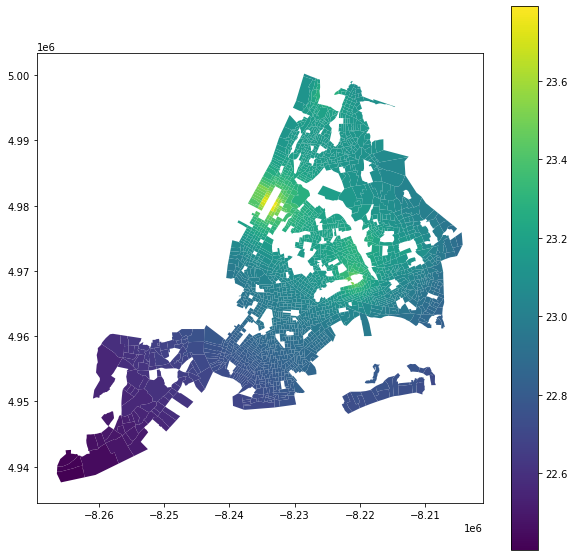

In [24]:
fig, ax=plt.subplots(figsize=(10,10))
tracts_acs.plot(column='log_A_euclid', ax=ax, legend=True)

In [83]:
#demos = tracts_acs[['percent_black','percent_asian', 'percent_latino','percent_poverty', 'percent_unemployed', 'percent_college_diploma', 'percent_unemployed',
       #'percent_indian', 'percent_islander', 'percent_SNAP', 'percent_noncitizen', 'med_age', 'percent_hsdiploma', 'med_income' ]]
#cols = [demo for demo in demos.columns]

#Y = tracts_acs['A_euclid']

#rsq_vals = {}

#def powerset(iterable):
    #"powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    #s = list(iterable)
    #return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

#for i, combo in enumerate(powerset(demos), 1):
    #X = demos[list(combo)]
    #X=sm.add_constant(X)
    #model=sm.OLS(Y,X, missing = 'drop').fit()
    #rsq_vals[combo]= model.rsquared

#key_max = max(rsq_vals, key=rsq_vals.get)

#print(f'Best variables {key_max} for a R-value of {round(rsq_vals[key_max], 5)}')

Best variables ('percent_black', 'percent_asian', 'percent_latino', 'percent_poverty', 'percent_unemployed', 'percent_college_diploma', 'percent_indian', 'percent_islander', 'percent_SNAP', 'percent_noncitizen', 'med_age', 'percent_hsdiploma', 'med_income') for a R-value of 0.17456


In [36]:
#best x for WITH %gardens below
#x=tracts_acs[['percent_black','percent_asian', 'percent_unemployed', 'percent_college_diploma','percent_noncitizen', 'med_age']]
#best x for WITHOUT %garden below
x=tracts_acs[['percent_black','percent_asian', 'percent_latino', 'percent_college_diploma', 'percent_noncitizen']]
y=tracts_acs[['A_euclid']]
y2=tracts_acs[['log_A_euclid']]

In [37]:
X = sm.add_constant(x) 
 
model = sm.OLS(y2, X).fit()
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:           log_A_euclid   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     121.0
Date:                Fri, 01 Jul 2022   Prob (F-statistic):          7.31e-112
Time:                        11:18:50   Log-Likelihood:                 672.78
No. Observations:                1980   AIC:                            -1334.
Df Residuals:                    1974   BIC:                            -1300.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [10]:
variables= tracts_acs[[ 'percent_black','percent_asian', 'percent_latino','percent_poverty', 'percent_college_diploma', 'percent_unemployed',
       'percent_indian', 'percent_islander', 'percent_SNAP', 'percent_noncitizen', 'med_age', 'percent_hsdiploma', 'med_income', 'pop_den' ]]

In [16]:
x=tracts_acs[['percent_black','percent_asian', 'percent_latino', 'percent_college_diploma', 'percent_SNAP', 'pop_den']]

In [17]:
pd.Series([variance_inflation_factor(x.values, i) 
               for i in range(x.shape[1])], 
              index=x.columns)

percent_black              1.662619
percent_asian              1.673739
percent_latino             3.227844
percent_college_diploma    2.840929
percent_SNAP               3.319105
pop_den                    3.940863
dtype: float64

In [264]:
coeffs = model.params
coeffs

const                      17.265567
percent_black               0.001412
percent_asian               0.001917
percent_latino              0.004889
percent_college_diploma     0.009775
percent_noncitizen          0.001270
dtype: float64

In [104]:
coeffs[1]

-0.0013330606734039295

In [266]:
tracts_acs['fit']=coeffs[0] + tracts_acs.percent_black*coeffs[1] + tracts_acs.percent_asian*coeffs[2]  + tracts_acs.percent_latino*coeffs[3]  + tracts_acs.percent_college_diploma*coeffs[4]  + tracts_acs.percent_noncitizen*coeffs[5]   

In [226]:
from sklearn.linear_model import Lasso, lasso_path

X,y=tracts_acs[['percent_black','percent_asian', 'percent_unemployed', 'percent_college_diploma',
    'percent_noncitizen', 'med_age']].values, tracts_acs['log_A_euclid'].values
clf= Lasso(alpha=.001)
clf.fit(X,y)


Lasso(alpha=0.001)

In [227]:
coeffs2=clf.coef_

In [228]:
coeffs2

array([-0.00133042, -0.00450285,  0.01205801,  0.01275353,  0.00782758,
       -0.00385564])

In [160]:
_, coef_path, _ = lasso_path(X, y, alphas=[1., .1, .01])
print(coef_path)

[[0.03628613 0.03207011 0.03156997]
 [0.0087517  0.00940718 0.0094823 ]
 [0.0664345  0.05920069 0.05837045]
 [0.1302308  0.13635635 0.13711316]
 [0.         0.21707583 0.2427943 ]
 [0.06234458 0.06485577 0.06509955]
 [0.28308183 0.26976114 0.26816354]]


In [ ]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap

In [120]:
from sklearn.metrics import r2_score

Text(0, 1, 'r-squared = -19.781')

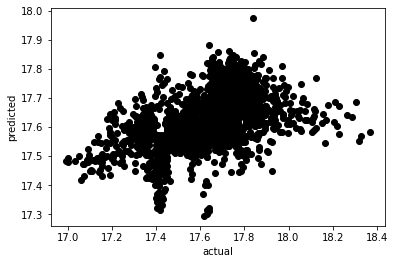

In [267]:
plt.plot(tracts_acs['log_A_euclid'], tracts_acs['fit'], 'o', color='black')
plt.ylabel('predicted')
plt.xlabel('actual')
plt.annotate("r-squared = {:.3f}".format(r2_score(tracts_acs['log_A_euclid'], tracts_acs['fit'])), (0, 1))

In [111]:
from scipy.stats import pearsonr

In [231]:
pearsonr(tracts_acs['log_A_euclid'], tracts_acs['fit'])

(0.4754382433726363, 3.293798541151912e-112)

In [232]:
r2_score(tracts_acs['log_A_euclid'], tracts_acs['fit'])

0.22604003196324618

In [113]:
tracts_acs2=tracts_acs[tracts_acs['log_A_euclid']<=17]

# GWR Test

In [47]:
#prepare tract data inputs
gy = tracts_acs['log_A_euclid'].values.reshape((-1, 1))
gX = tracts_acs[['percent_black','percent_asian', 'percent_latino', 'percent_college_diploma', 'percent_noncitizen']].values
u = tracts_acs['tractx']
v = tracts_acs['tracty']
tracts_coords = list(zip(u, v))

In [48]:
print(gy, gX)

[[22.88856378]
 [22.8810203 ]
 [22.96983215]
 ...
 [22.92868031]
 [23.72612727]
 [23.43816182]] [[44.51970443  1.97044335  9.42118227 18.81157635  7.38916256]
 [ 8.41362698  5.84996559 17.53269098 14.62491397  6.83069511]
 [49.56430812  1.63820146  9.41094458 20.91321018 11.8508191 ]
 ...
 [83.44537815  3.61344538  6.59663866 10.35714286  8.1302521 ]
 [ 0.68059701 10.17313433 12.08358209 33.20597015 11.94029851]
 [22.54482205 18.45062885 47.16350013 12.77762911 15.21273749]]


In [40]:
#Start MGWR test
#standardize the variables
gX = (gX - gX.mean(axis = 0)) / gX.std(axis = 0)
gy = (gy - gy.mean(axis = 0)) / gy.std(axis = 0)

In [41]:
#mgwr variables, notice that there are multiple bandwidths
mgwr_selector = Sel_BW(tracts_coords, gy, gX, multi = True)
mgwr_bw = mgwr_selector.search()
mgwr_results = MGWR(tracts_coords, gy, gX, mgwr_selector).fit()
mgwr_results.summary()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Model type                                                         Gaussian
Number of observations:                                                1980
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1515.634
Log-likelihood:                                                   -2544.908
AIC:                                                               5101.815
AICc:                                                              5103.872
BIC:                                                             -13468.709
R2:                                                                   0.235
Adj. R2:                                                              0.233

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [34]:
#Instantiate bandwidth selection object
selector = Sel_BW(tracts_coords, gy, gX)
#Default golden section search using AICc criterion
bw1 = selector.search()


#Interval search using AICc criterion
bw2 = selector.search(search_method = 'interval',
            interval = 1,
            bw_min = 25,
            bw_max = 75)
print(bw1, bw2)

54.0 43


<AxesSubplot:>

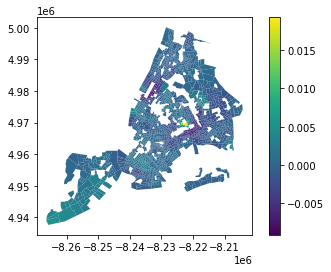

In [35]:
gwr_bw=bw1
gwr_model = GWR(tracts_coords, gy, gX, gwr_bw)
gwr_results = gwr_model.fit()
tracts_acs['gwr_pred'] = gwr_results.params[:, 1]
tracts_acs.plot(column='gwr_pred', legend=True)

<AxesSubplot:>

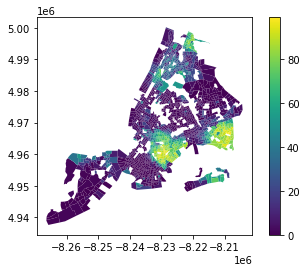

In [38]:
tracts_acs.plot(column='percent_black', legend=True)

In [39]:
len(gwr_results.params)

1980

<AxesSubplot:>

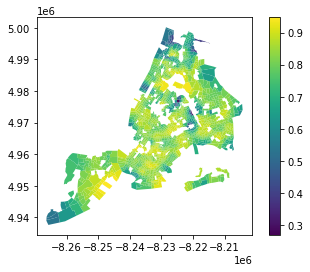

In [25]:
tracts_acs['R2'] = gwr_results.localR2
tracts_acs.plot(column='R2', legend=True)

In [26]:
np.mean(tracts_acs['R2'])

0.7977737047629548

In [35]:
filter_tc = gwr_results.filter_tvals()
filter_t = gwr_results.filter_tvals(alpha = 0.05)
tracts_acs['fb'] = gwr_results.params[:, 1]
tracts_acs['fb_t'] = filter_t[:, 1]
tracts_acs['fb_tc'] = filter_tc[:, 1]

Text(0.5, 1.0, 'Composite with correction')

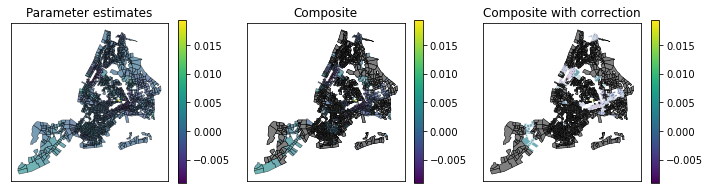

In [38]:
fig, ax = plt.subplots(1, 3, figsize = (12, 3))
tracts_acs.plot('fb',**{'edgecolor': 'black', 'alpha': .65,'linewidth': .5}, ax = ax[0], legend=True)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title('Parameter estimates')
tracts_acs.plot('fb', **{'edgecolor': 'black','alpha': .65,'linewidth': .5},ax = ax[1],legend=True)
tracts_acs[filter_t[:, 1] == 0].plot(color = 'grey',
                              ax = ax[1],
                              **{'edgecolor': 'black',
                                 'linewidth': .5})
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title('Composite')
tracts_acs.plot('fb',
            **{'edgecolor': 'white',
               'alpha': .65,
               'linewidth': .5},
            ax = ax[2],
            legend=True)
tracts_acs[filter_tc[:, 1] == 0].plot(color = 'grey',
                               ax = ax[2],
                               **{'edgecolor': 'black',
                                 'linewidth': .5})
ax[2].get_xaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[2].set_title('Composite with correction')

In [41]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                1980
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             58.756
Log-likelihood:                                                     672.785
AIC:                                                              -1333.569
AICc:                                                             -1331.512
BIC:                                                             -14925.586
R2:                                                                   0.235
Adj. R2:                                                              0.233

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [46]:
print(gy, gX)

array([[-0.7891732 ],
       [-0.82748586],
       [-0.37641828],
       ...,
       [-0.5854249 ],
       [ 3.4647382 ],
       [ 2.00218697]])

In [44]:
mgwr_selector.search()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

array([44., 44., 44., 44., 44., 44.])

In [ ]:
#https://stackoverflow.com/questions/67779818/finding-all-the-variables-that-give-the-highest-adjusted-r-squared-value

In [ ]:
#https://stats.stackexchange.com/questions/253334/how-to-solve-multicollinearity-problem-in-a-linear-regression
#https://stats.stackexchange.com/questions/51473/matrix-is-not-positive-definite-even-when-highly-correlated-variables-are-re/251050#251050
#https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python
#https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
#https://stackoverflow.com/questions/33568083/detecting-highly-correlated-attributes